# 정리
1. 몇 가지 기준으로 대상이 될 종목들을 가져온다
    - 시점 (매수 시점)에 따른 시가총액, 우선주 제외
2. change table에서 이 종목들의 대상 기간에 대한 가격정보를 가져온다
    - 대상 기간 (매수 고려 시점 : 매수 시점 - x개월) 에서의 누적 수익률을 계산한다.
3. 누적 수익률을 기준으로 종목을 분류한다.
4. 이를 반복하여 momentum 지표를 확인한다.

In [1]:
import pandas as pd
import FinanceDataReader as fdr
from datetime import datetime
from pykrx import stock
import re
from datetime import datetime

In [2]:
def date_str_bar (date):
    date_temp=str("%s-%02d-%02d" %(date.year, date.month, date.day))
    return date_temp
def date_str (date):
    date_temp=str("%s%02d%02d" %(date.year, date.month, date.day))
    return date_temp

## 자료 불러오기

In [3]:
# change_all = pd.read_csv('Raw_Price/change_all.csv',index_col=0)

finance_kospi = pd.read_csv('Raw_Finance/kospi_finance.csv',index_col=0).reset_index(drop=True)
finance_kospi['stock_code'] = finance_kospi['stock_code'].apply(lambda x : '%06d'%x)
finance_kosdaq = pd.read_csv('Raw_Finance/kosdaq_finance.csv',index_col=0).reset_index(drop=True)
finance_kosdaq['stock_code'] = finance_kosdaq['stock_code'].apply(lambda x : '%06d'%x)
finance_del = pd.read_csv('Raw_Finance/del_finance.csv',index_col=0).reset_index(drop=True)
finance_del['stock_code'] = finance_del['stock_code'].apply(lambda x : '%06d'%x)
finance = pd.concat([finance_kospi,finance_kosdaq,finance_del],axis=0)

## 대상 종목 선정하기

In [4]:
# 특정 시점에 시가총액, 거래대금 기준으로 대상이 되는 종목 list up
def make_stock_list_by_date (date : datetime, cap : int=10000000000,trade : int=100000000)->list:
    date = date_str(date)
    df_cap_kospi = stock.get_market_cap_by_ticker(date,market='KOSPI')
    df_cap_kosdaq = stock.get_market_cap_by_ticker(date, market='KOSDAQ')
    df_cap = pd.concat([df_cap_kospi,df_cap_kosdaq], axis=0)
    
    df_cap = df_cap[lambda df_cap : df_cap['시가총액'] > np.int64(cap)] #시가총액 100억 이상
    df_cap = df_cap[lambda df_cap : df_cap['거래대금'] > np.int64(trade)] #거래대금 1억 이상
    total_list = df_cap.index
    list_temp=[]
    p=re.compile('[0-9]*5$|[0-9]*7$|[0-9]*9$|[0-9]*K$|[0-9]*L$|[0-9]*M$|[0-9]*B$')
    for i in total_list:
        if not p.match(i):
            list_temp.append(i)
    return list_temp

In [189]:
def make_stock_list_by_date_cap (date : datetime, cap : int=10000000000,trade : int=100000000)->list:
    date = date_str(date)
    df_cap_kospi = stock.get_market_cap_by_ticker(date,market='KOSPI')
    df_cap_kosdaq = stock.get_market_cap_by_ticker(date, market='KOSDAQ')
    df_cap = pd.concat([df_cap_kospi,df_cap_kosdaq], axis=0)
    
    df_cap = df_cap[lambda df_cap : df_cap['시가총액'] > np.int64(cap)] #시가총액 100억 이상
    df_cap = df_cap[lambda df_cap : df_cap['거래대금'] > np.int64(trade)] #거래대금 1억 이상
    df_cap = df_cap.sort_values(by='시가총액',ascending=False) #시가총액 높은게 먼저
    total_list = df_cap.index
    list_temp=[]
    p=re.compile('[0-9]*5$|[0-9]*7$|[0-9]*9$|[0-9]*K$|[0-9]*L$|[0-9]*M$|[0-9]*B$')
    for i in total_list:
        if not p.match(i):
            list_temp.append(i)
    return list_temp

In [9]:
# 대상 종목을 대상 기간동안의 수익률 기준으로 오름차순 정렬
def make_stock_list_by_yield (stocks : list, bgn : datetime, end : datetime) -> list:
    change_stocks = change[stocks]
    yield_stocks = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).cumprod().tail(1)
    yield_stocks = yield_stocks.dropna(axis=1) #그 기간 중 상장한 경우 결측치로 나와 결측치를 제거함.
    stock_list = yield_stocks.T.sort_values(by=yield_stocks.index[0],ascending=True)
    return stock_list.index

In [153]:
#ID (정보이산) = sign(과거수익률) x [마이너스 수익률 비중(%)-플러스 수익률 비중(%)]
def make_stock_list_by_discrete (stocks : list, bgn : datetime, end : datetime) -> list:
    change_stocks = change[stocks]
    # sign(PERT) 를 계산하는 것은 2m-12m
    yield_stocks = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).cumprod().tail(1)
    yield_stocks = yield_stocks.dropna(axis=1) #그 기간 중 상장한 경우 결측치로 나와 결측치를 제거함.
    sign_stocks = yield_stocks.T[yield_stocks.index[0]].apply(lambda x:1 if x>1 else -1)
    
    # %neg-%pos 를 계산하는 것은 1m-12m (?) -> 아직은 2m-12m으로 함수구성됨.
    yield_count = change[yield_stocks.columns].loc[date_str_bar(bgn):date_str_bar(end),:]
    for i in yield_count.columns:
        yield_count[i] = yield_count[i].apply(lambda x: -1 if x>0 else 1)
    yield_count = yield_count.sum(axis=0)
    
    yield_id = pd.concat([pd.DataFrame(sign_stocks) ,pd.DataFrame(yield_count)],axis=1)
    yield_id['ID'] = yield_id[yield_id.columns[0]]*yield_id[yield_id.columns[1]]/len(yield_stocks.columns)
    stock_list = yield_id.sort_values(by='ID',ascending=False)
    return stock_list.index

## 대상기간의 가격정보 가져오기

In [86]:
from dateutil.relativedelta import relativedelta

In [6]:
def cal_yield_by_stock(stocks : list, bgn : datetime, end : datetime) -> float:
    change_stocks = change[stocks]
    yield_stocks = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).cumprod().tail(1)
    yield_sum = (yield_stocks.T.sum() / len(stocks)).values[0]
    return yield_sum

In [87]:
def cal_yield_by_stock_daily(stocks : list, bgn : datetime, end : datetime) :
    change_stocks = change[stocks]
    yield_sum = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).cumprod().sum(axis=1)/len(stocks)
    yield_list_temp = []
    yield_list_temp.append(yield_sum.values[0])
    for i in range(len(yield_sum.values)-1):
        yield_list_temp.append(yield_sum.values[i+1] / yield_sum.values[i])
    
#     yield_sum = (yield_stocks.T.sum() / len(stocks)).values[0]
    return pd.DataFrame(data=yield_list_temp,index=yield_sum.index)

# 재무정보 가져오기

In [42]:
def make_stock_list_by_finance(date : datetime, period : int, 
                               fs : pd.DataFrame, 
                               value_factors : list=[], 
                               quality_factors : list=[], 
                               momentum_factors : list=[]):
    #fs : financial statements
    
    # 기간의 재무제표와 시가총액 가져오기
    # 시가총액
    date = date_str(date_buy)
    df_cap_kospi = stock.get_market_cap_by_ticker(date,market='KOSPI')
    df_cap_kosdaq = stock.get_market_cap_by_ticker(date, market='KOSDAQ')
    df_cap = pd.concat([df_cap_kospi,df_cap_kosdaq], axis=0)
    df_cap['stock_code']=df_cap.index
    df_cap = df_cap[['stock_code','시가총액']]
    # 재무제표 -> 재무제표는 값이 없는 경우, 이전에 값을 가진 것 가져오는 것으로 수정 필요.
    fs = fs[fs['period'] == period]
    finance_cap = pd.merge(fs,df_cap,how='left')
    
    # 상장이전에도 재무제표에 값이 있어, 시가총액이 있는 기준으로 정렬
    finance_cap = finance_cap[~finance_cap['시가총액'].isnull()]
    
    # 초기화
    finance_cap['PBR_Score'] = 0
    finance_cap['PER_Score'] = 0
    finance_cap['PCR_Score'] = 0
    finance_cap['GP/A_Score'] = 0
    
    # value_factors
    if len(value_factors) != 0:
        for value_factor in value_factors:
            if value_factor == 'PBR':
                finance_cap['PBR'] = finance_cap['시가총액'] / finance_cap['지배자산']
                finance_cap.loc[finance_cap[finance_cap['PBR'].isnull()].index,'PBR'] = finance_cap['시가총액'] / finance_cap['총자산']
                finance_cap = finance_cap[finance_cap['PBR']>0]
                finance_cap = finance_cap.dropna(subset=['PBR']).sort_values(by='PBR',ascending=True)
                finance_cap['PBR_Score'] = np.arange(1,len(finance_cap.index)+1) / len(finance_cap.index)
            elif value_factor == 'PER':
                finance_cap['PER'] = finance_cap['시가총액'] / finance_cap['지배순이익']
                finance_cap.loc[finance_cap[finance_cap['PER'].isnull()].index,'PER'] = finance_cap['시가총액'] / finance_cap['당기순이익']
                finance_cap = finance_cap[finance_cap['PER']>0]
                finance_cap = finance_cap.dropna(subset=['PER']).sort_values(by='PER',ascending=True)
                finance_cap['PER_Score'] = np.arange(1,len(finance_cap.index)+1) / len(finance_cap.index)
            elif value_factor == 'PCR':
                finance_cap['PCR'] = finance_cap['시가총액'] / finance_cap['영업활동현금흐름']
                finance_cap = finance_cap[finance_cap['PCR']>0]
                finance_cap = finance_cap.dropna(subset=['PCR']).sort_values(by='PCR',ascending=True)
                finance_cap['PCR_Score'] = np.arange(1,len(finance_cap.index)+1) / len(finance_cap.index)
        finance_cap['Value_Score'] = (finance_cap['PBR_Score']+finance_cap['PER_Score']+finance_cap['PCR_Score']) / len(value_factors)
    
    # quality factors
    if len(quality_factors) != 0:
        for quality_factor in quality_factors:
            if quality_factor == 'GP/A':
                finance_cap['GP/A'] = finance_cap['매출총이익']/finance_cap['총자산']
                finance_cap.loc[finance_cap[finance_cap['GP/A'].isnull()].index,'GP/A'] = (finance_cap['매출액']-finance_cap['매출원가']) / finance_cap['총자산']
                finance_cap = finance_cap.dropna(subset=['GP/A']).sort_values(by='GP/A',ascending=False)
                finance_cap['GP/A_Score'] = np.arange(1,len(finance_cap.index)+1) / len(finance_cap.index)
        finance_cap['Quality_Score'] = (finance_cap['GP/A_Score']) / len(quality_factors)
    
    # momentum factors
    
    finance_cap['Total_Score'] = finance_cap['Value_Score'] + finance_cap['Quality_Score']
    finance_cap.sort_values(by='Total_Score',ascending=True,inplace=True)
    
    return finance_cap

In [44]:
date_buy = datetime(2018,4,15)
period = 201712

make_stock_list_by_finance(date=date_buy, period=period, fs=finance,
                          value_factors=['PBR','PER','PCR'],quality_factors=['GP/A'])
#932

The date you entered 20180415 seems to be a holiday. PYKRX changes the date parameter to 20180413 to query the requested information.
The date you entered 20180415 seems to be a holiday. PYKRX changes the date parameter to 20180413 to query the requested information.


,stock_code,period,총자산,현금,부채,지배자산,매출액,매출원가,매출총이익,판관비,...,PER_Score,PCR_Score,GP/A_Score,PBR,PER,PCR,Value_Score,GP/A,Quality_Score,Total_Score
1780,253590,201712,5.032791e+10,1.128389e+10,2.992220e+10,NaN,4.245224e+10,2.037140e+10,2.208084e+10,1.326350e+10,...,0.010733,0.134120,0.080447,0.217869,1.632715,4.140538,0.050150,0.438739,0.080447,0.130597
1787,256840,201712,2.375502e+10,6.900416e+09,1.436197e+10,NaN,1.501685e+10,5.697851e+09,9.319000e+09,6.270091e+09,...,0.042039,0.041845,0.098324,0.575036,4.767711,2.381477,0.073476,0.392296,0.098324,0.171800
496,095720,201712,5.339787e+11,9.702450e+10,2.310029e+11,3.003075e+11,6.243085e+11,2.755342e+11,3.487743e+11,3.145588e+11,...,0.216458,0.116953,0.026816,0.779331,9.389849,3.909946,0.190600,0.653161,0.026816,0.217415
388,032640,201712,1.193545e+13,4.498790e+11,6.702467e+12,5.232871e+12,1.188490e+13,2.929359e+12,8.955544e+12,8.108361e+12,...,0.220930,0.038627,0.013408,0.992892,9.494431,2.279374,0.208511,0.750331,0.013408,0.221919
1812,264850,201712,2.896880e+10,6.175213e+08,1.433210e+10,1.463671e+10,4.681299e+10,3.775034e+10,9.062642e+09,3.681898e+09,...,0.016100,0.082618,0.158659,0.642679,2.441857,3.349204,0.089798,0.312841,0.158659,0.248458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,031390,201712,1.204090e+11,4.833006e+08,7.224963e+10,4.815940e+10,1.953679e+10,1.028878e+10,9.248004e+09,6.059186e+09,...,0.955277,0.937768,0.889385,14.377246,216.279893,81.275007,0.953716,0.076805,0.889385,1.843102
1598,187420,201712,7.015090e+10,3.164301e+09,3.589536e+09,6.421851e+10,1.150597e+10,8.113442e+09,3.392530e+09,2.200435e+09,...,0.953488,0.978541,0.963128,4.530658,206.223107,213.334197,0.934068,0.048360,0.963128,1.897196
592,900140,201712,5.885968e+08,2.202277e+07,2.173837e+08,3.722500e+08,2.946923e+08,2.510757e+08,4.361662e+07,6.363029e+07,...,0.997317,0.998927,0.900559,644.261251,18218.051315,15317.673146,0.997815,0.074103,0.900559,1.898374
211,007460,201712,2.669857e+11,1.121088e+11,1.174296e+11,1.495561e+11,4.037567e+10,3.346274e+10,6.912927e+09,3.030551e+09,...,0.970483,0.949571,0.994413,5.308428,339.163624,98.325946,0.940895,0.025892,0.994413,1.935308


In [31]:
finance.isnull().sum()

stock_code      0
period          0
총자산            26
현금             27
부채             27
지배자산          399
매출액           241
매출원가          301
매출총이익         314
판관비           282
영업이익          177
당기순이익         224
지배순이익         707
영업활동현금흐름      104
dtype: int64

3/31 5/31 8/31 11/30

In [6]:
date_buy = datetime(2018,4,15)

date = date_str(date_buy)
df_cap_kospi = stock.get_market_cap_by_ticker(date,market='KOSPI')
df_cap_kosdaq = stock.get_market_cap_by_ticker(date, market='KOSDAQ')
df_cap = pd.concat([df_cap_kospi,df_cap_kosdaq], axis=0)
df_cap['stock_code']=df_cap.index
df_cap = df_cap[['stock_code','시가총액']]

The date you entered 20180415 seems to be a holiday. PYKRX changes the date parameter to 20180413 to query the requested information.
The date you entered 20180415 seems to be a holiday. PYKRX changes the date parameter to 20180413 to query the requested information.


In [7]:
period = '201712'

finance = finance[finance['period'] == int(period)]

In [8]:
finance_cap = pd.merge(finance,df_cap,how='left')

In [9]:
# 상장이전에도 재무제표에 값이 있어, 시가총액이 있는 기준으로 정렬
finance_cap = finance_cap[~finance_cap['시가총액'].isnull()]

In [10]:
finance_cap
# finance

,stock_code,period,총자산,현금,부채,지배자산,매출액,매출원가,매출총이익,판관비,영업이익,당기순이익,지배순이익,영업활동현금흐름,시가총액
0,000020,201712,3.672251e+11,3.158817e+10,7.028040e+10,2.969447e+11,2.588816e+11,1.507980e+11,1.080836e+11,8.301826e+10,1.098731e+10,4.700901e+10,4.700901e+10,-1.651997e+10,3.617125e+11
1,000040,201712,1.084432e+11,6.921567e+09,6.322164e+10,1.091087e+11,4.166189e+10,5.029874e+10,-8.636850e+09,1.739478e+10,-2.603163e+10,-3.150135e+10,-3.071873e+10,-4.731789e+09,7.341268e+10
2,000050,201712,1.274042e+12,9.482362e+09,5.749082e+11,6.991527e+11,3.607888e+11,2.534422e+11,1.073466e+11,6.503735e+10,4.230923e+10,2.531536e+10,2.531469e+10,5.772057e+10,3.961507e+11
3,000070,201712,3.275960e+12,9.852000e+10,1.336172e+12,1.373532e+12,2.396290e+12,1.974916e+12,4.213740e+11,2.456750e+11,9.882800e+10,6.718600e+10,3.767500e+10,-2.188000e+10,7.862001e+11
4,000080,201712,3.507596e+12,2.874424e+11,2.290087e+12,1.216822e+12,1.889910e+12,1.086067e+12,8.038428e+11,7.165931e+11,8.724975e+10,1.273597e+10,1.268216e+10,3.449079e+11,1.444752e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966,226350,201712,4.760712e+10,1.018055e+09,2.499781e+10,NaN,1.052900e+10,6.744638e+09,3.784363e+09,4.986406e+09,-1.202042e+09,-2.096465e+10,NaN,-4.496920e+09,8.363396e+10
1967,900040,201712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.847940e+08,-1.117517e+08,NaN,NaN,NaN,1.023295e+11
1968,900080,201712,2.560312e+09,7.882276e+08,6.998389e+07,2.490328e+09,9.391046e+08,6.833016e+08,2.558030e+08,1.211477e+07,1.691328e+08,1.193917e+08,1.193917e+08,1.846034e+08,9.092410e+10
1969,900090,201712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.686044e+07,-5.684797e+08,NaN,NaN,NaN,7.266200e+10


In [23]:
finance_cap['PBR'] = finance_cap['시가총액'] / finance_cap['지배자산']

In [40]:
finance_cap.loc[finance_cap[finance_cap['PBR'].isnull()].index,'PBR'] = finance_cap['시가총액'] / finance_cap['총자산']

In [50]:
finance_cap = finance_cap[finance_cap['PBR']>0]

In [54]:
finance_cap = finance_cap.dropna(subset=['PBR']).sort_values(by='PBR',ascending=True)

In [63]:
finance_cap['PBR_Score'] = np.arange(1,len(finance_cap.index)+1) / len(finance_cap.index)

In [64]:
finance_cap

,stock_code,period,총자산,현금,부채,지배자산,매출액,매출원가,매출총이익,판관비,영업이익,당기순이익,지배순이익,영업활동현금흐름,시가총액,PBR,PER,PBR_Score
632,008830,201712,1.834716e+11,8.895884e+09,1.231424e+11,NaN,1.134930e+11,1.051875e+11,8.305496e+09,1.330339e+09,2.996656e+09,7.153229e+07,NaN,1.087164e+10,2.498531e+10,0.136181,349.287093,1
1022,053660,201712,1.808084e+11,5.235041e+09,1.768755e+11,NaN,1.377794e+11,1.352475e+11,2.531851e+09,9.477474e+09,-6.945623e+09,-1.634895e+10,NaN,-5.533380e+09,2.541762e+10,0.140578,-1.554695,2
649,012700,201712,1.114805e+12,1.379116e+10,7.974975e+11,NaN,4.401744e+11,3.923432e+11,NaN,NaN,4.783116e+10,3.621850e+10,NaN,-1.305771e+11,1.677177e+11,0.150446,4.630719,3
695,021320,201712,9.420808e+11,2.373474e+11,6.039461e+11,NaN,1.326422e+12,1.199075e+12,1.273469e+11,5.549425e+10,7.185265e+10,2.248332e+10,NaN,1.025493e+11,1.639240e+11,0.174002,7.290915,4
1243,082660,201712,1.813607e+11,2.000657e+09,1.200506e+11,NaN,1.844190e+11,1.846296e+11,-2.105911e+08,1.380219e+10,-1.401278e+10,-2.960536e+10,NaN,-3.906235e+09,3.178522e+10,0.175260,-1.073631,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,950140,201712,8.628586e+07,6.555088e+06,2.997555e+07,NaN,7.705375e+07,6.601793e+07,1.103582e+07,1.888122e+07,-7.845392e+06,-1.227223e+07,NaN,-8.382280e+06,1.160283e+11,1344.696989,-9454.545453,1783
1894,950130,201712,8.715350e+07,6.471600e+06,3.666812e+07,41125261.0,2.605564e+07,1.796974e+07,8.085892e+06,1.414850e+07,-6.062605e+06,-8.142363e+06,-5735367.0,-5.082426e+06,1.594124e+11,3876.265678,-27794.635932,1784
229,008700,201712,1.304733e+08,4.221758e+06,6.580444e+07,64668896.0,1.558963e+08,1.334096e+08,2.248671e+07,1.937734e+07,3.109367e+06,-1.529552e+06,-1529552.0,1.854931e+06,2.525838e+11,3905.800178,-165135.794991,1785
1882,900100,201712,7.366808e+07,7.694789e+06,2.599737e+07,47609465.0,3.324263e+07,3.130626e+07,1.936367e+06,1.313912e+07,-1.120275e+07,-1.926893e+07,-20205619.0,-1.476062e+07,2.421118e+11,5085.371946,-11982.401414,1786


In [43]:
finance_cap['PER'] = finance_cap['시가총액'] / finance_cap['지배순이익']

In [44]:
finance_cap.loc[finance_cap[finance_cap['PER'].isnull()].index,'PER'] = finance_cap['시가총액'] / finance_cap['당기순이익']

In [33]:
a = finance_cap[finance_cap['PBR'].isnull()]

In [37]:
a.index

Int64Index([  50,   74,   86,  104,  254,  279,  348,  358,  368,  428,
            ...
            1954, 1955, 1956, 1959, 1962, 1965, 1966, 1967, 1969, 1971],
           dtype='int64', length=321)

In [62]:
len(set(finance.stock_code))

2193

In [32]:
from collections import Counter
a=Counter(finance_kospi['period'])

In [37]:
from pykrx import stock
date = datetime(2010,4,15)
date = date_str(date)
cap = stock.get_market_cap_by_ticker(date, market='KOSPI')
cap

,종가,시가총액,거래량,거래대금,상장주식수
티커,,,,,
005930,855000,125940933135000,365104,310702197000,147299337
005490,538000,46906517230000,319758,171894231000,87186835
005380,119000,26212901001000,1129764,133002686000,220276479
015760,36600,23481378259200,2122601,77353666850,641567712
055550,49100,23283199721700,3457476,171955180450,474199587
...,...,...,...,...,...
012405,9500,228000000,220,2045000,24000
018415,178500,202419000,0,0,1134
017555,190000,193800000,1,190000,1020


In [43]:
cap['stock_code']=cap.index
cap = cap[['stock_code','시가총액']]

In [5]:
# finance = finance_kospi[finance_kospi['period'] == 201012]
finance

,stock_code,period,총자산,현금,부채,지배자산,매출액,매출원가,매출총이익,판관비,영업이익,당기순이익,지배순이익,영업활동현금흐름
0,000020,202103,4.372693e+11,5.890616e+10,9.606559e+10,3.296506e+11,2.768989e+11,1.342833e+11,1.426157e+11,9.966666e+10,2.556582e+10,3.196671e+10,3.169340e+10,3.846881e+10
1,000020,202012,4.338078e+11,5.859643e+10,9.112556e+10,3.312555e+11,2.720754e+11,1.334094e+11,1.386660e+11,9.860051e+10,2.315337e+10,2.871510e+10,2.850769e+10,5.222823e+10
2,000020,202009,4.245615e+11,7.239734e+10,9.229299e+10,3.256000e+11,2.867462e+11,1.500011e+11,1.367451e+11,9.602175e+10,2.356772e+10,2.839715e+10,2.840519e+10,4.644059e+10
3,000020,202006,3.882905e+11,1.114818e+11,7.710188e+10,3.111886e+11,2.943950e+11,1.637952e+11,1.305998e+11,9.655638e+10,1.705682e+10,1.687545e+10,1.688353e+10,4.423788e+10
4,000020,202003,3.761859e+11,7.573369e+10,7.669876e+10,2.994871e+11,2.994903e+11,1.760521e+11,1.234382e+11,9.688905e+10,9.968394e+09,9.524724e+09,9.532891e+09,3.235969e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3394,900180,201012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.737514e+07,2.537124e+08,NaN,NaN,NaN
3395,950010,201612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.620700e+08,NaN,NaN,NaN
3396,950010,201512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.060690e+08,NaN,NaN,NaN
3397,950010,201412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.777410e+08,NaN,NaN,NaN


In [46]:
a = pd.merge(finance,cap,how='left')

In [56]:
b = a[~a['시가총액'].isnull()]

In [57]:
b['총자산'] = b['총자산']/b['시가총액']
b

,stock_code,period,총자산,현금,부채,지배자산,매출액,매출원가,매출총이익,판관비,영업이익,당기순이익,지배순이익,영업활동현금흐름,시가총액
0,000020,201012,1.972623,1.814100e+10,1.161906e+11,NaN,2.152794e+11,1.154542e+11,9.982518e+10,8.295070e+10,1.687449e+10,1.100414e+10,NaN,1.162879e+10,1.689854e+11
1,000040,201012,1.595589,2.844524e+10,7.797406e+10,NaN,1.447542e+11,1.260337e+11,1.872054e+10,1.447292e+10,4.247620e+09,-5.004782e+08,-2.635388e+08,1.914225e+10,9.068562e+10
2,000050,201012,5.111221,1.893618e+10,6.961170e+11,6.333765e+11,3.393560e+11,2.331667e+11,1.061893e+11,6.165604e+10,4.453325e+10,2.006063e+10,2.010542e+10,1.047593e+10,2.600000e+11
3,000070,201012,5.530974,1.720870e+11,8.732030e+11,1.233258e+12,1.064390e+12,9.155420e+11,1.488480e+11,8.613200e+10,5.017100e+10,1.114750e+11,1.189600e+11,9.487400e+10,4.342837e+11
4,000080,201012,0.908855,1.548371e+11,8.077033e+11,6.094099e+11,1.066403e+12,6.195039e+11,4.468991e+11,3.180883e+11,1.288108e+11,4.762038e+10,4.754886e+10,1.271579e+11,1.559578e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,114090,201012,0.225483,2.025858e+11,1.466026e+11,NaN,4.824295e+11,3.497483e+11,1.326812e+11,3.346305e+10,9.921816e+10,7.383871e+10,NaN,8.240952e+10,1.500000e+12
470,115390,201012,0.361947,6.449433e+10,5.738997e+10,3.940281e+11,3.862417e+11,1.871558e+11,1.990859e+11,1.158815e+11,8.320439e+10,6.600371e+10,6.600503e+10,-9.547338e+09,1.247500e+12
472,118000,201012,2.437245,5.882178e+08,5.352737e+10,2.235232e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.113339e+10
473,119650,201012,1.629978,4.332950e+10,7.856242e+10,NaN,2.452720e+11,2.053743e+11,3.989771e+10,1.666175e+10,2.323596e+10,2.031517e+10,NaN,5.705528e+09,8.287500e+10


In [ ]:
# 특정시점 기준

In [24]:
finance_kospi[finance_kospi['period'] == 202012]

,stock_code,period,총자산,현금,부채,지배자산,매출액,매출원가,매출총이익,판관비,영업이익,당기순이익,지배순이익,영업활동현금흐름
1,000020,202012,4.338078e+11,5.859643e+10,9.112556e+10,3.312555e+11,2.720754e+11,1.334094e+11,1.386660e+11,9.860051e+10,2.315337e+10,2.871510e+10,2.850769e+10,5.222823e+10
37,000040,202012,1.558735e+11,2.741839e+10,1.060284e+11,1.305097e+11,1.178344e+11,9.796812e+10,1.986625e+10,1.864723e+10,1.219024e+09,-1.148601e+10,-8.131057e+09,8.847016e+09
73,000050,202012,1.264902e+12,3.954576e+10,5.229722e+11,7.419529e+11,3.292247e+11,2.323986e+11,9.682610e+10,7.497211e+10,2.185400e+10,1.302570e+10,1.302837e+10,3.363565e+10
109,000070,202012,3.893565e+12,1.875830e+11,1.737778e+12,1.519653e+12,2.471226e+12,1.951116e+12,5.201100e+11,3.497740e+11,1.703360e+11,1.432650e+11,1.023130e+11,2.454880e+11
145,000080,202012,3.297784e+12,2.645056e+11,2.223506e+12,1.073794e+12,2.256323e+12,1.281305e+12,9.750178e+11,7.765393e+11,1.984786e+11,8.662849e+10,8.669525e+10,3.827926e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20494,348950,202012,1.814910e+12,6.038535e+10,9.919871e+11,8.229233e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20499,352820,202012,1.924443e+12,3.802439e+11,7.255032e+11,1.195335e+12,7.962834e+11,4.215381e+11,3.747453e+11,2.292296e+11,1.455156e+11,8.706112e+10,8.572076e+10,1.166770e+11
20503,353200,202012,8.091771e+11,2.262470e+10,1.713962e+11,6.377809e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20507,363280,202012,2.003568e+12,7.293905e+10,7.107834e+11,1.091444e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 기간에 따른 수익률 정보 취합하기

In [191]:
buy = datetime(2010,1,1)
momen = 5
gap = 1
duration_stock_estimation = 11
duration_stock_selection = 3
duration_trade = 1 #매월 rebalancing
discrete = 3
cap = 3

In [135]:
# Momentum 지표 사용
start = datetime(2010,1,1)
change = change_all
df_yield = pd.DataFrame()
for i in range(50):
    buy = start + relativedelta(months=duration_stock_selection*i)
#     print(buy)
    if buy > datetime(2021,6,1):
        break
    stock_list = make_stock_list_by_date(buy)
    stock_list_by_yield = make_stock_list_by_yield(stock_list, bgn=buy-relativedelta(months = gap+duration_stock_estimation),
                                                   end=buy-relativedelta(months = gap))
    #rebalancing
    for j in range(int(duration_stock_selection/duration_trade)):
        buy_rebal = buy + relativedelta(months=j)
        df_yield_partial = pd.DataFrame()
        # momentum기준으로 나눈 그룹마다 계산
        for k in range(momen):
            stock_list_temp = stock_list_by_yield[int(len(stock_list_by_yield)/(momen)*k):int(len(stock_list_by_yield)/(momen)*(k+1))]
            # rebalance할때마다가 아닌 daily기준으로 수익률 data를 넣기
            df_yield_temp_partial = cal_yield_by_stock_daily(stocks=stock_list_temp,bgn=buy_rebal,end=buy_rebal+relativedelta(months = duration_trade))
            df_yield_temp_partial.rename(columns={0:k},inplace=True)
            df_yield_partial = pd.concat([df_yield_partial,df_yield_temp_partial],axis=1)
        df_yield_temp = df_yield_partial
        df_yield = pd.concat([df_yield,df_yield_temp],axis=0)
df_yield.rename(columns={0:'Low',4:'High'},inplace=True)

The date you entered 20100101 seems to be a holiday. PYKRX changes the date parameter to 20091230 to query the requested information.
The date you entered 20100101 seems to be a holiday. PYKRX changes the date parameter to 20091230 to query the requested information.
The date you entered 20110101 seems to be a holiday. PYKRX changes the date parameter to 20101230 to query the requested information.
The date you entered 20110101 seems to be a holiday. PYKRX changes the date parameter to 20101230 to query the requested information.
The date you entered 20111001 seems to be a holiday. PYKRX changes the date parameter to 20110930 to query the requested information.
The date you entered 20111001 seems to be a holiday. PYKRX changes the date parameter to 20110930 to query the requested information.
The date you entered 20120101 seems to be a holiday. PYKRX changes the date parameter to 20111229 to query the requested information.
The date you entered 20120101 seems to be a holiday. PYKRX cha

In [195]:
# 시가총액 + Momentum 지표 사용
start = datetime(2010,1,1)
change = change_all
df_yield = pd.DataFrame()
for i in range(50):
    buy = start + relativedelta(months=duration_stock_selection*i)
#     print(buy)
    if buy > datetime(2021,6,1):
        break
    # 시가총액기준 & 시가총액 높은것부터 정렬
    stock_list_by_cap = make_stock_list_by_date_cap(buy)
    # Momentum 지표 낮은것부터 정렬
    stock_list_by_yield = []
    for part in range(cap):
        stock_list_temp_partial = stock_list_by_cap[int(len(stock_list_by_cap)/cap*part):int(len(stock_list_by_cap)/cap*(part+1))]
        stock_list_temp_partial = make_stock_list_by_yield(stock_list_temp_partial, bgn=buy-relativedelta(months = gap+duration_stock_estimation),
                                                          end=buy-relativedelta(months = gap))
        stock_list_by_yield = stock_list_by_yield + list(stock_list_temp_partial)
    
    #rebalancing
    for j in range(int(duration_stock_selection/duration_trade)):
        buy_rebal = buy + relativedelta(months=j)
        df_yield_partial = pd.DataFrame()
        for k in range(cap*momen):
            stock_list_temp = stock_list_by_yield[int(len(stock_list_by_yield)/(cap*momen)*k):int(len(stock_list_by_yield)/(cap*momen)*(k+1))]
            # rebalance할때마다가 아닌 daily기준으로 수익률 data를 넣기
            df_yield_temp_partial = cal_yield_by_stock_daily(stocks=stock_list_temp,bgn=buy_rebal,end=buy_rebal+relativedelta(months = duration_trade))
            df_yield_temp_partial.rename(columns={0:k},inplace=True)
            df_yield_partial = pd.concat([df_yield_partial,df_yield_temp_partial],axis=1)
        df_yield_temp = df_yield_partial
        df_yield = pd.concat([df_yield,df_yield_temp],axis=0)
df_yield.rename(columns={0:'High Cap Low Momen',4:'High Cap High Momen',10:'Low Cap Low Momen',14:'Low Cap High Momen'},inplace=True)

The date you entered 20100101 seems to be a holiday. PYKRX changes the date parameter to 20091230 to query the requested information.
The date you entered 20100101 seems to be a holiday. PYKRX changes the date parameter to 20091230 to query the requested information.
The date you entered 20110101 seems to be a holiday. PYKRX changes the date parameter to 20101230 to query the requested information.
The date you entered 20110101 seems to be a holiday. PYKRX changes the date parameter to 20101230 to query the requested information.
The date you entered 20111001 seems to be a holiday. PYKRX changes the date parameter to 20110930 to query the requested information.
The date you entered 20111001 seems to be a holiday. PYKRX changes the date parameter to 20110930 to query the requested information.
The date you entered 20120101 seems to be a holiday. PYKRX changes the date parameter to 20111229 to query the requested information.
The date you entered 20120101 seems to be a holiday. PYKRX cha

In [168]:
# Momentum 지표 + discrete 지표 사용
start = datetime(2010,1,1)
change = change_all
df_yield = pd.DataFrame()
for i in range(50):
    buy = start + relativedelta(months=duration_stock_selection*i)
#     print(buy)
    if buy > datetime(2021,6,1):
        break
    stock_list = make_stock_list_by_date(buy)
    stock_list_by_yield = make_stock_list_by_yield(stock_list, bgn=buy-relativedelta(months = gap+duration_stock_estimation),
                                                   end=buy-relativedelta(months = gap))
    # partial로 구분된 stock_list를 각각 discrete기준으로 재정렬
    stock_list_by_yield_discrete = []
    for part in range(momen):
        stock_list_temp_partial = stock_list_by_yield[int(len(stock_list_by_yield)/momen*part):int(len(stock_list_by_yield)/momen*(part+1))]
        stock_list_temp_partial = make_stock_list_by_discrete(stock_list_temp_partial, bgn=buy-relativedelta(months = gap+duration_stock_estimation), 
                                                              end=buy-relativedelta(months = gap))
        stock_list_by_yield_discrete = stock_list_by_yield_discrete + list(stock_list_temp_partial)
    stock_list_by_yield = stock_list_by_yield_discrete
    
    #rebalancing
    for j in range(int(duration_stock_selection/duration_trade)):
        buy_rebal = buy + relativedelta(months=j)
#         yield_list = []
        df_yield_partial = pd.DataFrame()
        for k in range(momen*discrete):
            stock_list_temp = stock_list_by_yield[int(len(stock_list_by_yield)/(momen*discrete)*k):int(len(stock_list_by_yield)/(momen*discrete)*(k+1))]
            # rebalance할때마다가 아닌 daily기준으로 수익률 data를 넣기
            df_yield_temp_partial = cal_yield_by_stock_daily(stocks=stock_list_temp,bgn=buy_rebal,end=buy_rebal+relativedelta(months = duration_trade))
            df_yield_temp_partial.rename(columns={0:k},inplace=True)
            df_yield_partial = pd.concat([df_yield_partial,df_yield_temp_partial],axis=1)
        df_yield_temp = df_yield_partial
        df_yield = pd.concat([df_yield,df_yield_temp],axis=0)
df_yield.rename(columns={0:'Low_Discrete',2:'Low_Continuous',12:'High_Discrete',14:'High_Continuous'},inplace=True)

The date you entered 20100101 seems to be a holiday. PYKRX changes the date parameter to 20091230 to query the requested information.
The date you entered 20100101 seems to be a holiday. PYKRX changes the date parameter to 20091230 to query the requested information.
The date you entered 20110101 seems to be a holiday. PYKRX changes the date parameter to 20101230 to query the requested information.
The date you entered 20110101 seems to be a holiday. PYKRX changes the date parameter to 20101230 to query the requested information.
The date you entered 20111001 seems to be a holiday. PYKRX changes the date parameter to 20110930 to query the requested information.
The date you entered 20111001 seems to be a holiday. PYKRX changes the date parameter to 20110930 to query the requested information.
The date you entered 20120101 seems to be a holiday. PYKRX changes the date parameter to 20111229 to query the requested information.
The date you entered 20120101 seems to be a holiday. PYKRX cha

In [196]:
# 리밸런싱하는 시점은 이전과 이후 두번이 계산되기 때문에, df_yield의 index에서 중복으로 입력되어있다.
# 리벌랜싱 이후만을 사용하기 위해 중복 중에 마지막 것만 사용한다.
# df_yield.groupby(df_yield.index).first()
df_yield = df_yield.groupby(df_yield.index).last()

In [ ]:
df_yield.to_csv('Product/Momentum_Cap_5partial_11m_est_w_1m_gap_3m_selec_1m_rebal.csv')

# 누적 그래프 작성

In [239]:
import matplotlib.pyplot as plt
import matplotlib.dates as md

In [244]:
def date_to_date (date):
    date = date.split('-')
    date_new = datetime(int(date[0]),int(date[1]),int(date[2]))
    return date_new

In [245]:
df_yield.index = [date_to_date(date) for date in df_yield.index ]

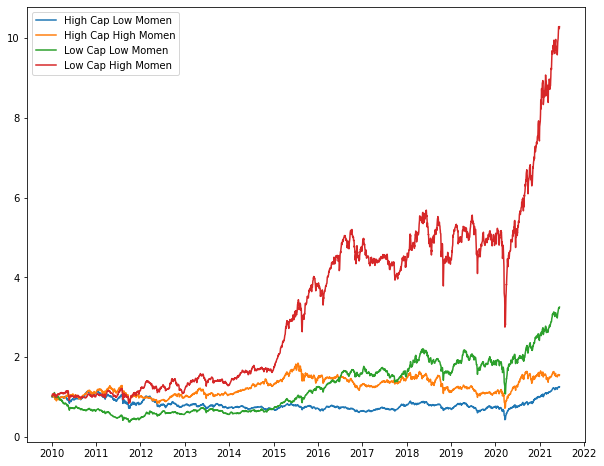

In [254]:
to_show = ['High Cap Low Momen','High Cap High Momen','Low Cap Low Momen','Low Cap High Momen']
fig, ax = plt.subplots(1,1,figsize=(10,8))
for i in range(len(to_show)):
    ax.plot(df_yield.cumprod()[to_show[i]])
ax.xaxis.set_major_locator(md.YearLocator(1,month=1,day=1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y'))
plt.legend(to_show)
plt.show()

기타코드

In [ ]:
# 우선주 등 제외하기
# stock_code_list 정제하기 (우선주, 리츠, 옵션) -> 6자리 숫자만, 맨 앞자리에 0 들어가는 것만
import re
stock_code_list = []
for stock_code in df_cap.index:
    stock_code = re.findall("\d+", stock_code)[0] # 숫자만 추출한 뒤 첫번째 것만 사용
    if (stock_code[-1] == '0') and (len(stock_code) == 6):
        stock_code_list.append(stock_code)
len(stock_code_list)

In [ ]:
from collections import Counter
a = Counter(df_yield.index.to_list())
a.most_common()

In [ ]:
df_yield[df_yield.index == '2010-02-01']